In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [6]:
data = pd.read_csv('../data/international-airline-passengers.csv', engine='python', skipfooter=3)
data.columns = ['Month','#Passengers']
data['Month'] = pd.to_datetime(data['Month'],format='%Y-%m')
data.set_index('Month', inplace=True)
data

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [7]:
data.dtypes

#Passengers    int64
dtype: object

In [8]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [9]:
ts = data['#Passengers']

In [13]:
train_size = int(len(ts) * 0.67)
test_size = len(ts) - train_size
train, test = ts[0:train_size], ts[train_size:len(ts)]
print(train.head())
print(test.head())

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64
Month
1957-01-01    315
1957-02-01    301
1957-03-01    356
1957-04-01    348
1957-05-01    355
Name: #Passengers, dtype: int64


### Estimating & Eliminating Trend

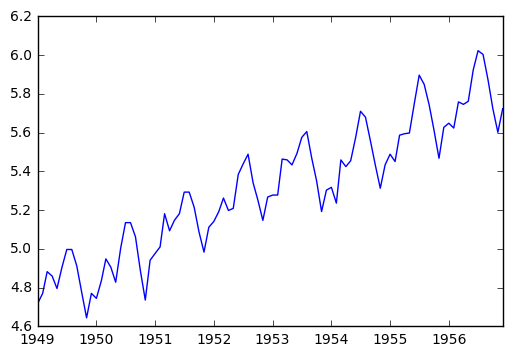

In [14]:
train_log = np.log(train)
plt.plot(train_log)

### Diferencing

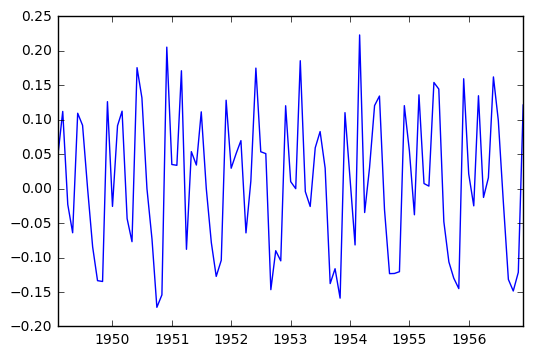

In [26]:
train_log_diff = train_log - train_log.shift()
train_log_diff.dropna(inplace=True)
plt.plot(train_log_diff)

### ARIMA Model

In [27]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Santiago\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


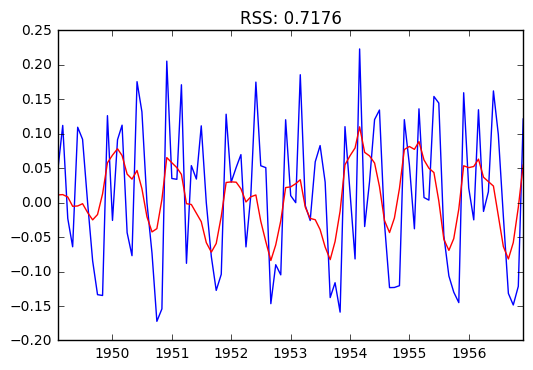

In [28]:
model = ARIMA(train_log, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-train_log_diff)**2))

### Converting to original scale

In [32]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.011257
1949-03-01    0.011711
1949-04-01    0.008209
1949-05-01   -0.005264
1949-06-01   -0.004796
dtype: float64

In [33]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.011257
1949-03-01    0.022968
1949-04-01    0.031178
1949-05-01    0.025914
1949-06-01    0.021118
dtype: float64

In [34]:
predictions_ARIMA_log = pd.Series(train_log.ix[0], index=train_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.729756
1949-03-01    4.741467
1949-04-01    4.749677
1949-05-01    4.744413
dtype: float64

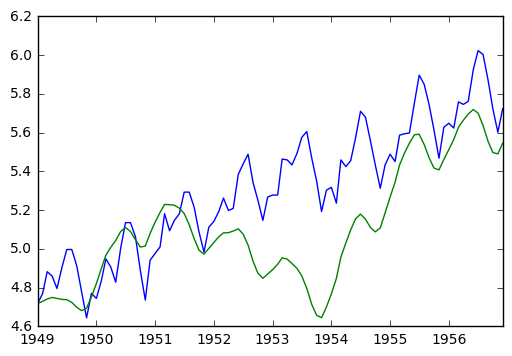

In [35]:
plt.plot(train_log)
plt.plot(predictions_ARIMA_log)

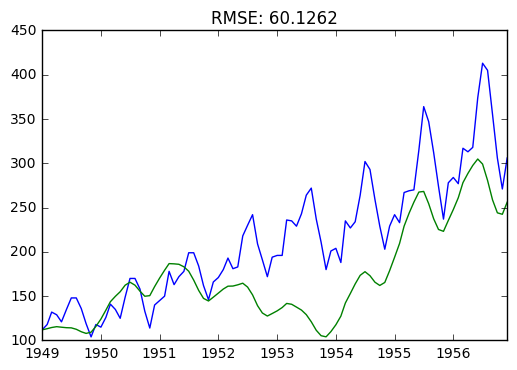

In [37]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(train)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-train)**2)/len(train)))